## Logistic Regression: Examples 1 -- 2D data fit with multinomial model and 0 1 digits classification on MNIST dataset.

This post will be mostly Python code with implementation and examples of the Logistic Regression theory we have been discussing in the last few posts. Examples include fitting to 2 feature data using an arbitrary order multinomial model and a simple 2 class image classification problem using the MNIST digits data.

I've done three earlier posts on Logistic Regression, [Logistic Regression Theory](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Theory-988/) and [Logistic and Linear Regression Regularization](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-and-Linear-Regression-Regularization-994/), [Logistic Regression Implementation](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Logistic-Regression-Implementation-996/). Those posts include discussion of logistic regression theory and derivation of the equations with the purpose of giving insight on how it works. The last post included a simple Python implementation of the equations and a simple example. 

This will be a "calculator" style implementation using Python in this Jupyter notebook. This will hopefully lift some of the veil off of black-box implementations in packages like [scikit-learn](http://scikit-learn.org/stable/). The code should be fairly easy to "tinker" with.

I'll also exercise a "best practice" in data science by dividing the MNIST dataset into training-validation-test subsets for analysis.

>This posts along with all of the others in this series were converted to html from Jupyter notebooks. The notebooks are available at [https://github.com/dbkinghorn/blog-jupyter-notebooks](https://github.com/dbkinghorn/blog-jupyter-notebooks)


## Python functions to implement Logistic Regression

To understand what is being implemented here refer to the previous posts mentioned near the top of this post. 

**Note: I have fixed a couple of bugs in code that I had in the last post. These were related to Python variable and function scoping.**  


In [1]:
import pandas as pd  # data handeling
import numpy as np   # numerical computing
from scipy.optimize import minimize  # optimization code
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  
%matplotlib inline
sns.set()
import itertools  # combinatorics functions for multinomial code

In [2]:
#
# Main Logistic Regression Equations
#
def g(z) :  # sigmoid function
    return 1.0/(1.0 + np.exp(-z))

def h_logistic(X,a) : # Model function
    return g(np.dot(X,a))

def J(X,a,y) : # Cost Function 
    m = y.size
    return -(np.sum(np.log(h_logistic(X,a))) + np.dot((y-1).T,(np.dot(X,a))))/m

def J_reg(X,a,y,reg_lambda) : # Cost Function with Regularization
    m = y.size
    return J(X,a,y) + reg_lambda/(2.0*m) * np.dot(a[1:],a[1:])

def gradJ(X,a,y) : # Gradient of Cost Function
    m = y.size
    return (np.dot(X.T,(h_logistic(X,a) - y)))/m

def gradJ_reg(X,a,y,reg_lambda) : # Gradient of Cost Function with Regularization
    m = y.size
    return gradJ(X,a,y) + reg_lambda/(2.0*m) * np.concatenate(([0], a[1:])).T

<hr />
For the model checking function I have added all of the data for a ["confusion matrix"](https://en.wikipedia.org/wiki/Confusion_matrix) i.e. true positive, true negative, false positive and false negative. Using that data I ahve added ["Precision" and "Recall"](https://en.wikipedia.org/wiki/Precision_and_recall) measures.

In [3]:
#
# Some model checking functions
#
def to_0_1(h_prob) : # convert probabilites to true (1) or false (0) at cut-off 0.5
    return np.where(h_prob >= 0.5, 1, 0)

def model_accuracy(h,y) : # Overall accuracy of model
    return np.sum(h==y)/y.size * 100 

def model_accuracy_pos(h,y) : # Accuracy on positive cases
    return np.sum(y[h==1] == 1)/y[y==1].size * 100
    
def model_accuracy_neg(h,y) : # Accuracy on negative cases
    return np.sum(y[h==0] == 0)/y[y==0].size * 100
    
def false_pos(h,y) : # Number of false positives
    return np.sum((y==0) & (h==1))

def false_neg(h,y) : # Number of false negatives
    return np.sum((y==1) & (h==0))

def true_pos(h,y) : # Number of true positives
    return np.sum((y==1) & (h==1))

def true_neg(h,y) : # Number of true negatives
    return np.sum((y==0) & (h==0))
    
def model_precision(h,y) : # Precision = TP/(TP+FP)
    return true_pos(h,y)/(true_pos(h,y) + false_pos(h,y))

def model_recall(h,y) : # Recall = TP/(TP+FN)
    return true_pos(h,y)/(true_pos(h,y) + false_neg(h,y))

def print_model_quality(title, h, y) : # Print the results of the functions above
    print( '\n# \n# {} \n#'.format(title) )
    print( 'Total number of data points   = {}'.format(y.size))
    print( 'Number of Positive values(1s) = {}'.format(y[y==1].size))
    print( 'Number of Negative values(0s) = {}'.format(y[y==0].size))
    print( '\nNumber of True Positives = {}'.format(true_pos(h,y)) )
    print( 'Number of False Positives = {}'.format(false_pos(h,y)) )
    print( '\nNumber of True Negatives = {}'.format(true_neg(h,y)) )
    print( 'Number of False Negatives = {}'.format(false_neg(h,y)) )
    print( '\nModel Accuracy = {:.2f}%'.format( model_accuracy(h,y) ) )
    print( 'Model Accuracy Positive Cases = {:.2f}%'.format( model_accuracy_pos(h,y) ) )
    print( 'Model Accuracy Negative Cases = {:.2f}%'.format( model_accuracy_neg(h,y) ) )
    print( '\nModel Precision = {}'.format(model_precision(h,y)) )
    print( '\nModel Recall = {}'.format(model_recall(h,y)) )
    


<hr />
I added the following "utility functions" to generate multinomial features and apply mean normalization to features. Normalization is particularly important in Logistic regression. 

In [4]:
def multinomial_partitions(n, k):
    """returns an array of length k sequences of integer partitions of n"""
    nparts = itertools.combinations(range(1, n+k), k-1)
    tmp = [(0,) + p + (n+k,) for p  in nparts]
    sequences =  np.diff(tmp) - 1
    return sequences[::-1] # reverse the order

def make_multinomial_features(fvecs,order=[1,2]) :
    '''Make multinomial feature matrix
       fvecs is a matrix of feature vectors (columns)
       "order" is a set of multinomial degrees to create 
       default is [1,2] meaning for example: given f1, f2 in fvecs
       return a matrix made up of a [1's column, f1,f2,f1**2,f1*f2,f2**2]   '''
    Xtmp = np.ones_like(fvecs[:,0])
    for ord in order :
        if ord==1 :
            fstmp = fvecs
        else :
            pwrs = multinomial_partitions(ord,fvecs.shape[1])
            fstmp = np.column_stack( ( np.prod(fvecs**pwrs[i,:], axis=1) for i in range(pwrs.shape[0]) ))

        Xtmp = np.column_stack((Xtmp,fstmp))
    return Xtmp

def mean_normalize(X):
    '''apply mean normalization to each column of the matrix X'''
    X_mean=X.mean(axis=0)
    X_std=X.std(axis=0)
    return (X-X_mean)/X_std

def apply_normalizer(X,X_mean,X_std) :
    return (X-X_mean)/X_std

## Example of 2-D data using a multinomial feature model

This first example is a variation of data that I used when describing "decision boundaries". I have made it a little more complicated and will use multinomial "feature expansion" on the two feature variables. This will also include some over-fitting and Regularization cases.


In [5]:
# Generate some "interesting" random 2-D data
np.random.seed(42)
px1, px2 = np.random.multivariate_normal([0,0], [[1,0.2],[0.8,1]] , 100).T
t = np.linspace(0,2*np.pi,100)
nx1, nx2 = (3+px1)*np.sin(t), (3+px2)*np.cos(t)

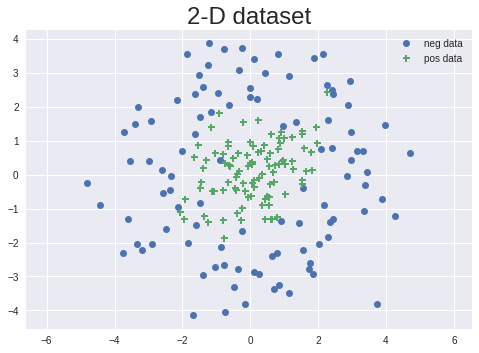

In [6]:
# Plot the data
fig, ax = plt.subplots()
ax.plot(nx1,nx2, "o", label='neg data' )
ax.plot(px1,px2, "P", label='pos data')
ax.axis('equal')
plt.title("2-D dataset", fontsize=24)
ax.legend();

<hr />
We will obviously need a non-linear feature model to fit this data. We'll start by setting the data up for a logistic regression optimization run using a hybrid multinomial feature set that looks like,

### $ [1, f_1, f_2, f_1^2, f_1 f_2, f_2^2 ]$
 

In [7]:
f1 = np.concatenate((nx1,px1))
f2 = np.concatenate((nx2,px2))
fs = np.column_stack((f1,f2))
y = np.concatenate( (np.zeros(100), (np.ones(100))) )

order = np.array([1,2])
X = make_multinomial_features(fs,order=order)
X[:,1:] = mean_normalize(X[:,1:])  # normalize but leave the bias term alone
print('Number of multinolial features = {}'.format(X.shape[1]))

Number of multinolial features = 6


<hr />
Before the optimization run we need to setup wrappers around the cost functions and the gradient so they are in the correct for the optimization code. 

In [8]:
def opt_J_reg(a) :
    return J_reg(X,a,y,reg)

def opt_gradJ_reg(a) :
    return gradJ_reg(X,a,y,reg)

<hr />
Now do an optimization run to find the parameters $a$ for the model.

In [9]:
reg = 0.0 # no regularization on this run
def opt_J_reg(a) :
    return J_reg(X,a,y,reg)

def opt_gradJ_reg(a) :
    return gradJ_reg(X,a,y,reg)
aguess = np.ones(X.shape[1]) # make a random starting guess

res = minimize(opt_J_reg, aguess, method='BFGS', jac=opt_gradJ_reg, tol=1e-4, options={'disp': True}) 

Optimization terminated successfully.
         Current function value: 0.174379
         Iterations: 38
         Function evaluations: 40
         Gradient evaluations: 40


<hr />
Take a quick look at the optimizied $a$,

In [10]:
a_opt = res.x
print(a_opt)

[-2.55931254 -0.0870605   0.71439094 -5.44404492  2.52102583 -5.27329538]


<hr />
Here's some data about the quality of the fit,

In [11]:
h_prob = h_logistic(X,a_opt)  # get the probabilities of the from the model using a_opt
h_predict = to_0_1(h_prob)    # convert the probabilities to 0,1 predictions at cutoff 0.5
print_model_quality('Traing-data fit', h_predict, y)


# 
# Traing-data fit 
#
Total number of data points   = 200
Number of Positive values(1s) = 100
Number of Negative values(0s) = 100

Number of True Positives = 95
Number of False Positives = 8

Number of True Negatives = 92
Number of False Negatives = 5

Model Accuracy = 93.50%
Model Accuracy Positive Cases = 95.00%
Model Accuracy Negative Cases = 92.00%

Model Precision = 0.9223300970873787

Model Recall = 0.95


<hr />
That looks like a reasonably good fit to the data. (I am not doing validation and test set checking for this example) 

Lets take a look at a plot of the fit,

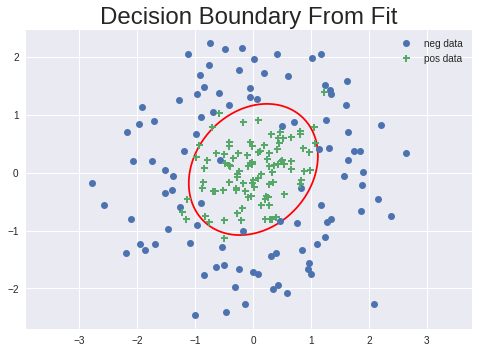

In [12]:
fig, ax = plt.subplots()
ax.plot(X[0:100,1],X[0:100,2], "o", label='neg data' )
ax.plot(X[100:,1],X[100:,2], "P", label='pos data')

xb1 = np.linspace(-1.5, 1.5, 100)
xb2 = np.linspace(-1.5, 1.5, 100)

#Xb1, Xb2 = np.meshgrid(mean_normalize(xb1), mean_normalize(xb2))
Xb1, Xb2 = np.meshgrid(xb1, xb2)

BX = make_multinomial_features(np.column_stack((Xb1.flatten(),Xb2.flatten())),order=order)
BX[:,1:] = mean_normalize(BX[:,1:])

B = np.sum(a_opt*BX, axis=1).reshape((100,100))

ax.contour(Xb1,Xb2,B, colors='r', levels=[0])

ax.axis('equal')
plt.title("Decision Boundary From Fit", fontsize=24)
plt.legend();

<hr />
Now we'll try the fit using a multinomial feature set up to order 6!

### $ [1, f_1, f_2, f_1^2, f_1 f_2, f_2^2,f_1^3 \cdots,f_1f_2^5, f_2^6 ]$

In [13]:
order = np.array([1,2,3,4,5,6])
X = make_multinomial_features(fs,order=order)
X[:,1:] = mean_normalize(X[:,1:])  # normalize but leave the bias term alone
print('Number of multinomial features = {}'.format(X.shape[1]))

Number of multinomial features = 28


In [14]:
reg = 0.0 # no regularization on this run

aguess = np.ones(X.shape[1]) # make a random starting guess

res = minimize(opt_J_reg, aguess, method='BFGS', jac=opt_gradJ_reg, tol=1e-4, options={'disp': True}) 

         Current function value: 0.133673
         Iterations: 123
         Function evaluations: 140
         Gradient evaluations: 130


/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/kinghorn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [15]:
a_opt = res.x
print(a_opt)

[-25.83054628   1.91599264  -2.18003373  -7.23297228  -4.42150473
  -9.04500407  -4.85325203  16.09550436 -16.15373297   4.33889798
 -16.21215182  41.0905519   -3.18469102  10.23059434  -4.22973383
 -12.93519374 -23.72944353  13.27775859  10.43000405  12.19747541
  -3.36204064 -14.25716642 -14.97108344 -24.36744587  -4.68677728
  -7.52314346  -1.31983794  -7.71650312]


<hr />
The optimization had some trouble because of the size of the parameters and gave warnings about divide by zero.

In [16]:
h_prob = h_logistic(X,a_opt)  # get the probabilities of the from the model using a_opt
h_predict = to_0_1(h_prob)    # convert the probabilities to 0,1 predictions at cutoff 0.5
print_model_quality('Traing-data fit', h_predict, y)


# 
# Traing-data fit 
#
Total number of data points   = 200
Number of Positive values(1s) = 100
Number of Negative values(0s) = 100

Number of True Positives = 96
Number of False Positives = 7

Number of True Negatives = 93
Number of False Negatives = 4

Model Accuracy = 94.50%
Model Accuracy Positive Cases = 96.00%
Model Accuracy Negative Cases = 93.00%

Model Precision = 0.9320388349514563

Model Recall = 0.96


<hr />
The model fit quality does look good. Let's look at a plot of the fit,

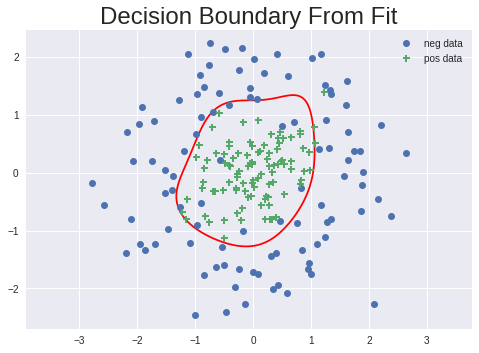

In [17]:
fig, ax = plt.subplots()
ax.plot(X[0:100,1],X[0:100,2], "o", label='neg data' )
ax.plot(X[100:,1],X[100:,2], "P", label='pos data')

xb1 = np.linspace(-1.5, 1.5, 100)
xb2 = np.linspace(-1.5, 1.5, 100)

#Xb1, Xb2 = np.meshgrid(mean_normalize(xb1), mean_normalize(xb2))
Xb1, Xb2 = np.meshgrid(xb1, xb2)

BX = make_multinomial_features(np.column_stack((Xb1.flatten(),Xb2.flatten())),order=order)
BX[:,1:] = mean_normalize(BX[:,1:])

B = np.sum(a_opt*BX, axis=1).reshape((100,100))

ax.contour(Xb1,Xb2,B, colors='r', levels=[0])

ax.axis('equal')
plt.title("Decision Boundary From Fit", fontsize=24)
plt.legend();

<hr />
The plot looks OK but the model boundary is getting a bit wobbly. Let's try it again with a small regularization value added.

In [18]:
reg = 1.0 # no regularization on this run

aguess = np.ones(X.shape[1]) # make a random starting guess

res = minimize(opt_J_reg, aguess, method='BFGS', jac=opt_gradJ_reg, tol=1e-4, options={'disp': True}) 

         Current function value: 0.243149
         Iterations: 22
         Function evaluations: 89
         Gradient evaluations: 78


In [19]:
a_opt = res.x
print(a_opt)

[-2.03340023  0.29231676  0.24372954 -2.84129446  0.75850419 -2.78556633
 -0.10303138  0.14859169  0.0797471  -0.06084818 -1.09411076  0.1178533
 -0.77473628  0.21184059 -1.23582341  0.03323504  0.18950555  0.16011281
  0.16747923  0.4755728   0.01901587 -0.22881667  0.13537621  0.08746756
  0.24180835  0.09574047  0.21421962 -0.42770074]


In [20]:
h_prob = h_logistic(X,a_opt)  # get the probabilities of the from the model using a_opt
h_predict = to_0_1(h_prob)    # convert the probabilities to 0,1 predictions at cutoff 0.5
print_model_quality('Traing-data fit', h_predict, y)


# 
# Traing-data fit 
#
Total number of data points   = 200
Number of Positive values(1s) = 100
Number of Negative values(0s) = 100

Number of True Positives = 96
Number of False Positives = 8

Number of True Negatives = 92
Number of False Negatives = 4

Model Accuracy = 94.00%
Model Accuracy Positive Cases = 96.00%
Model Accuracy Negative Cases = 92.00%

Model Precision = 0.9230769230769231

Model Recall = 0.96


<hr />
Now the parameters $a$ are closer to 1 and the optimization no longer has a divide by zero warning but it is still complaining about convergence. The fit quality looks good. Lets take a look at a plot,

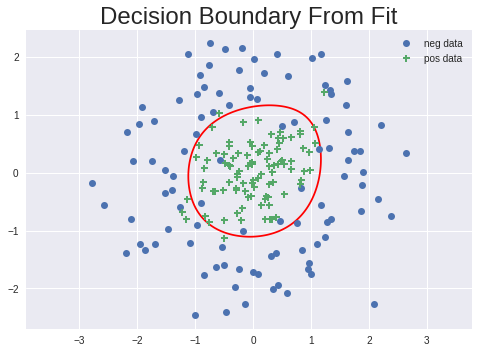

In [21]:
fig, ax = plt.subplots()
ax.plot(X[0:100,1],X[0:100,2], "o", label='neg data' )
ax.plot(X[100:,1],X[100:,2], "P", label='pos data')

xb1 = np.linspace(-1.5, 1.5, 100)
xb2 = np.linspace(-1.5, 1.5, 100)

#Xb1, Xb2 = np.meshgrid(mean_normalize(xb1), mean_normalize(xb2))
Xb1, Xb2 = np.meshgrid(xb1, xb2)

BX = make_multinomial_features(np.column_stack((Xb1.flatten(),Xb2.flatten())),order=order)
BX[:,1:] = mean_normalize(BX[:,1:])

B = np.sum(a_opt*BX, axis=1).reshape((100,100))

ax.contour(Xb1,Xb2,B, colors='r', levels=[0])

ax.axis('equal')
plt.title("Decision Boundary From Fit", fontsize=24)
plt.legend();

<hr />
The plot boundary is smoother and probably a more reasonable model. I hope this example has given you some idea of how multinomial features and regularization can effect model fitting for Logistic Regression. 

**This is really kind of fun to play around with! If you want to try the code and experiment yourself feel free to grad the Jupyter notebook from the GitHub link I gave near the top of the post.** 

In the next section we'll look at a simple image classification example. 

## Two class Image classification example using data from the MNIST dataset

For this example I pulled the [MNIST training set from **Kaggle**](https://www.kaggle.com/c/digit-recognizer/data). For information on the dataset itself see [Yann Lecun's site http://yann.lecun.com/exdb/mnist/index.html](http://yann.lecun.com/exdb/mnist/index.html). I used the data from Kaggel since it is in an easy to use format. ([Kaggle](https://www.kaggle.com/) is a great site for Machine Learning and there are many useful datasets and example problems there.)  

The reason I only pulled the training set from Kaggel is because I want to explicitly show splitting up a dataset into separate sets for training. validation, and testing. The training set should be the largest set since that is where the model fitting takes place. The validation set is used for evaluating the effect of making adjustments to "hyper-parameters" of the method used to construct the model. The test set is the finial judge of the "generalization" or usefulness of the model for making predictions.

The first thing to do is load up the data and have a look at it,

In [22]:
data_full = pd.read_csv("./data/kg-mnist/train.csv")
data_full.head(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<hr />
The data is laid out with each row being an image with the image label (0-9) as the first element of the row. The following 784 columns are the 28 x 28 pixie image "flattened out" as a vector of gray-scale values. The 784 pixel gray-scale intensities are the "features".

I'll convert the dataframe to a matrix and show the image in the 6th row (a 7). There are 42000 images in this dataset.

In [23]:
data_full_matrix=data_full.as_matrix()
print(data_full_matrix.shape)

(42000, 785)


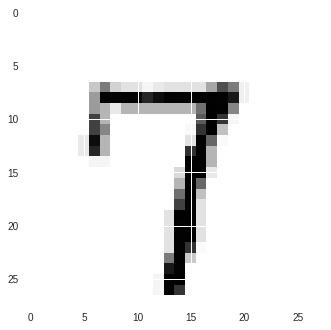

In [24]:
plt.imshow(data_full_matrix[6,1:].reshape((28,28)))

The image is shown fairly large on the screen. You can clearly see the pixels and their relative gray-scale values.

<hr />
Now I'll pull out just the 0 1nd 1 images (data_01) and the corresponding labels (y_01),

In [25]:
idx = np.logical_or(data_full_matrix[:,0]==0,  data_full_matrix[:,0]==1)

y_01, data_01 = data_full_matrix[idx,0], data_full_matrix[idx,1:]
print(data_01.shape)

(8816, 784)


There are now 8816 images of 0's and 1's in (data_01). Some of the feature columns in data_01 have all 0 gray-scale values i.e. they are empty boarders. Let's remove those "features". We will have 588 columns in data_01 after their removal.  

In [26]:
data_01 = data_01[:,data_01.sum(axis=0)!=0]
print(data_01.shape)

(8816, 588)


<hr />
The next thing to do is break up the data set in training, validation and test sets. I'll print out the shapes of the datasets and label vectors. We will have 6170 training samples and 1323 samples for validation and testing.

In [27]:
data_train_01,y_train_01 = data_01[0:6170,:],     y_01[0:6170]
data_val_01, y_val_01    = data_01[6170:7493,:],  y_01[6170:7493]
data_test_01, y_test_01  = data_01[7493:,:],      y_01[7493:]

print(data_train_01.shape,y_train_01.shape)
print(data_val_01.shape, y_val_01.shape)
print(data_test_01.shape, y_test_01.shape)

(6170, 588) (6170,)
(1323, 588) (1323,)
(1323, 588) (1323,)


<hr />
Next we setup the data for the optimization run. We want the data to all be normalized by the same mean and standard deviation so that all of the sets are scaled in the same way. I'll pull the mean and standard deviation from the full 0,1 dataset data_01 and apply it to all of the datasets.

At the same time I'll setup the augmented matrix with ones in the first column for the bias term using the make_multinomial_features function using "order" set to [1]. [I could add multinomial features but that gets to be VERY large ... I tried it and am still experimenting with subsets :-)]

In [28]:
X_mean = data_01.mean(axis=0)
X_std  = data_01.std(axis=0)
X_std[X_std==0]=1.0 # if there are any 0 values in X_std set them to 1

order = np.array([1])

X_train = make_multinomial_features(data_train_01, order=order)
X_train[:,1:] = apply_normalizer(X_train[:,1:],X_mean,X_std)
y_train = y_train_01

X_val = make_multinomial_features(data_val_01, order=order)
X_val[:,1:] = apply_normalizer(X_val[:,1:],X_mean,X_std)
y_val = y_val_01

X_test = make_multinomial_features(data_test_01, order=order)
X_test[:,1:] = apply_normalizer(X_test[:,1:],X_mean,X_std)
y_test = y_test_01


### Optimization run on Training set

In [29]:
def opt_J_reg(a) :
    return J(X_train,a,y_train)

def opt_gradJ_reg(a) :
    return gradJ_reg(X_train,a,y_train,reg)

In [30]:
reg =1.0
aguess = np.random.randn(X_train.shape[1])
%time res = minimize(opt_J_reg, aguess, method='CG', jac=opt_gradJ_reg, tol=1e-4, options={'disp': True}) 

         Current function value: 0.000063
         Iterations: 21
         Function evaluations: 315
         Gradient evaluations: 303
CPU times: user 30.4 s, sys: 572 ms, total: 30.9 s
Wall time: 7.75 s


In [31]:
a_opt = res.x
h_prob = h_logistic(X_train,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Traing-data fit', h_predict, y_train)


# 
# Traing-data fit 
#
Total number of data points   = 6170
Number of Positive values(1s) = 3288
Number of Negative values(0s) = 2882

Number of True Positives = 3288
Number of False Positives = 0

Number of True Negatives = 2882
Number of False Negatives = 0

Model Accuracy = 100.00%
Model Accuracy Positive Cases = 100.00%
Model Accuracy Negative Cases = 100.00%

Model Precision = 1.0

Model Recall = 1.0


<hr />
**We got a 100% fit to the training data!** Note: I changed the optimizer to conjugate gradients since it is usually better for larger numbers of optimization parameters. I also have a small regularization value set to help stabalize the optimization.

### Results on Validation set
This is our first test of how well the fit is "really" doing. 100% is hard to argue with for the training set!

In [32]:
a_opt = res.x
h_prob = h_logistic(X_val,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Validation-data fit', h_predict, y_val)


# 
# Validation-data fit 
#
Total number of data points   = 1323
Number of Positive values(1s) = 700
Number of Negative values(0s) = 623

Number of True Positives = 697
Number of False Positives = 4

Number of True Negatives = 619
Number of False Negatives = 3

Model Accuracy = 99.47%
Model Accuracy Positive Cases = 99.57%
Model Accuracy Negative Cases = 99.36%

Model Precision = 0.9942938659058488

Model Recall = 0.9957142857142857


<hr />
All we had to do here is use the optimized vales in $a$ with our validation set to see how well the model predicts values on that. It looks pretty good with only 7 total miss-classifications out or 1323 total.

Maybe our "perfect" fit on the training set was too good. I can try adjusting the regularization term to see if we can get a model that is still good on the training set but does a better job on the validation set. (this is what the validation set is for!)

In [33]:
reg = 15.0

np.random.seed(42) # just make sure I'm using the same random guess every time I run

aguess = np.random.randn(X_train.shape[1])
%time res = minimize(opt_J_reg, aguess, method='CG', jac=opt_gradJ_reg, tol=1e-4, options={'disp': True}) 

a_opt = res.x
h_prob = h_logistic(X_train,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Traing-data fit', h_predict, y_train)

a_opt = res.x
h_prob = h_logistic(X_val,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Validation-data fit', h_predict, y_val)

         Current function value: 0.000410
         Iterations: 14
         Function evaluations: 180
         Gradient evaluations: 168
CPU times: user 17.5 s, sys: 396 ms, total: 17.9 s
Wall time: 4.49 s

# 
# Traing-data fit 
#
Total number of data points   = 6170
Number of Positive values(1s) = 3288
Number of Negative values(0s) = 2882

Number of True Positives = 3288
Number of False Positives = 0

Number of True Negatives = 2882
Number of False Negatives = 0

Model Accuracy = 100.00%
Model Accuracy Positive Cases = 100.00%
Model Accuracy Negative Cases = 100.00%

Model Precision = 1.0

Model Recall = 1.0

# 
# Validation-data fit 
#
Total number of data points   = 1323
Number of Positive values(1s) = 700
Number of Negative values(0s) = 623

Number of True Positives = 700
Number of False Positives = 1

Number of True Negatives = 622
Number of False Negatives = 0

Model Accuracy = 99.92%
Model Accuracy Positive Cases = 100.00%
Model Accuracy Negative Cases = 99.84%

Model Precision =

<hr />
After a few minutes of trying different values for the regularization 15.0 seemed to be about as good as was going to get for both the training and validation set. This value resulted in just 1 missed prediction out of 1323.

Now lets see how the test set looks,

### Results on Test set


In [34]:
a_opt = res.x
h_prob = h_logistic(X_test,a_opt)
h_predict = to_0_1(h_prob)
print_model_quality('Test-data fit', h_predict, y_test)


# 
# Test-data fit 
#
Total number of data points   = 1323
Number of Positive values(1s) = 696
Number of Negative values(0s) = 627

Number of True Positives = 692
Number of False Positives = 3

Number of True Negatives = 624
Number of False Negatives = 4

Model Accuracy = 99.47%
Model Accuracy Positive Cases = 99.43%
Model Accuracy Negative Cases = 99.52%

Model Precision = 0.99568345323741

Model Recall = 0.9942528735632183


<hr />
OK there it is! The test set has 7 errors out of 1323, not bad for simple Logistic Regression!

Nest time I extend this to **Multi-Class** Logistic Regression using a method called one-vs-all. With that we can do the whole set of digits 0-9.

**Happy computing! --dbk** 